In [13]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split
import cv2
import os
import matplotlib.pyplot as plt
from utils.model import BaseModel
from utils.metrics import CategoryAccuracy

device = "cuda" if torch.cuda.is_available() else "cpu"   
print(f"Using {device} device")

Using cpu device


In [14]:
eps = 0.01

def FGSM(model, x, y, loss_func = torch.nn.CrossEntropyLoss(), epsilon = eps):
    model.eval()
    x.requires_grad = True
    pred = model(x)
    loss = loss_func(pred, y)
    loss.backward()
    signed_grad = torch.sign(x.grad)
    adv_x = x + epsilon * signed_grad
    adv_x = torch.clamp(adv_x, 0.0, 1.0)
    return adv_x

In [15]:
path = "../ORL3232/"
folders = sorted(os.listdir(path)[:-1], key = lambda x : int(x))

imgs = []
labels = []

for folder in folders:
    p = path + folder + '/'
    files = os.listdir(p)
    files = [p+x for x in files if x.endswith(".bmp")]
    for file in files:
        img = cv2.imread(file, 0) / 255.0
        imgs.append(np.reshape(img, [32, 32, 1]))
        labels.append(int(folder) - 1)

print("done")

done


In [16]:
x_data = imgs.copy() * 2
y_data = labels.copy() * 2

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2)

x_train = torch.tensor(np.array(x_train), dtype=torch.float32)
x_train = torch.permute(x_train, [0, 3, 1, 2])
y_train = torch.tensor(np.array(y_train), dtype=torch.int64)

x_test = torch.tensor(np.array(x_test), dtype=torch.float32)
x_test = torch.permute(x_test, [0, 3, 1, 2])
y_test = torch.tensor(np.array(y_test), dtype=torch.int64)

assert x_train.shape[0] == y_train.shape[0]

In [17]:
class Model(BaseModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.pool = torch.nn.MaxPool2d(2)
        self.flat = torch.nn.Flatten()
        self.relu = torch.nn.ReLU()
        self.conv1 = torch.nn.Conv2d(1, 24, 3)
        self.conv2 = torch.nn.Conv2d(24, 16, 3)
        self.conv3 = torch.nn.Conv2d(16, 12, 3)
        self.linear1 = None
        self.linear2 = torch.nn.Linear(64, 64)
        self.linear3 = torch.nn.Linear(64, 40)
    
    def forward(self, input):
        x = input
        x = self.relu(self.pool(self.conv1(x)))
        x = self.relu(self.pool(self.conv2(x)))
        x = self.relu(self.pool(self.conv3(x)))
        x = self.flat(x)
        if self.linear1 is None:
            self.linear1 = torch.nn.Linear(x.shape[1], 64).to(x.device)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.linear3(x)
        return x

In [18]:
model = Model().to(device)
opt = torch.optim.Adam(model.parameters())
model.compile(opt, torch.nn.CrossEntropyLoss(), CategoryAccuracy(len(folders)), device)

In [19]:
history = model.fit(x_train, y_train, 8, 50)

Epoch 50/50: 100%|██████████| 80/80 [00:00<00:00, 120.66batch/s, loss=0.0572, accuracy=0.997]


In [20]:
print("Accuracy of clean data : {}".format(model.evaluate(x_test, y_test)))

adv_x = FGSM(model, x_test, y_test)
print("Accuracy of adversarial data : {}".format(model.evaluate(adv_x, y_test)))

Accuracy of clean data : 0.9625
Accuracy of adversarial data : 0.44375


In [21]:
torch.save(model, "base_model.pt")

In [22]:
class AdversarialModel(BaseModel):
    def __init__(self, base_model, FGSM):
        super().__init__()
        self.base_model = base_model
        self.fgsm = FGSM

    def forward(self, inputs):
        if self.training:
            x, y = inputs 
            adv_x = self.fgsm(self.base_model, x, y)  
            clean_preds = self.base_model(x)
            adv_preds = self.base_model(adv_x)
            return (clean_preds, adv_preds)
        else:
            try:
                x, _ = inputs
            except:
                x = inputs 
            return self.base_model(x)

In [23]:
class AdversarialLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.loss_func = torch.nn.CrossEntropyLoss()

    def forward(self, y_pred, y_true):
        clean_preds, adv_preds = y_pred
        loss_clean = self.loss_func(clean_preds, y_true)
        loss_adv = self.loss_func(adv_preds, y_true)
        return 0.5 * loss_clean + 0.5 * loss_adv

In [ ]:
model_adv = AdversarialModel(torch.load("base_model.pt"), FGSM).to(device)
opt_adv = torch.optim.Adam(model_adv.parameters())
model_adv.compile(opt_adv, AdversarialLoss(), CategoryAccuracy(len(folders)), device=device)

In [25]:
history_adv = model_adv.fit((x_train, y_train), y_train, 8, 50)

Epoch 50/50: 100%|██████████| 80/80 [00:01<00:00, 47.52batch/s, loss=0.165, accuracy=1]


In [26]:
print("Accuracy of clean data : {}".format(model_adv.evaluate(x_test, y_test)))

adv_x = FGSM(model_adv, x_test, y_test)
print("Accuracy of adversarial data : {}".format(model_adv.evaluate(adv_x, y_test)))

Accuracy of clean data : 0.975
Accuracy of adversarial data : 0.79375


In [27]:
def display_images(img, adv_img, model, model_adv):
    model.eval()
    model_adv.eval()
    fig, axes = plt.subplots(2, 2)
    epsilons = [0, eps]
    descriptions = ['Epsilon = {:0.3f}'.format(eps) for eps in epsilons]
    for i in range(2):
        for j in range(2):
            description = "Origin Model, " + descriptions[i] if j == 0 else "Adv Model, " + descriptions[i]
            if i == 0:
                pred = model(img) if j == 0 else model_adv(img)
                label = torch.argmax(pred, -1).item()
                confidence = torch.softmax(pred, -1)[0, label]
                axes[i, j].imshow(cv2.cvtColor(torch.permute(img, [0, 2, 3, 1])[0].detach().numpy(), cv2.COLOR_BGR2RGB))
                axes[i, j].set_title('{} \n {} : {:.2f}% Confidence'.format(description, label, confidence*100))
                axes[i, j].axis('off')
            else:
                pred = model(adv_img[0]) if j == 0 else model_adv(adv_img[1])
                label = torch.argmax(pred, -1).item()
                confidence = torch.softmax(pred, -1)[0, label]
                axes[i, j].imshow(cv2.cvtColor(torch.permute(adv_img[j], [0, 2, 3, 1])[0].detach().numpy(), cv2.COLOR_BGR2RGB))
                axes[i, j].set_title('{} \n {} : {:.2f}% Confidence'.format(description, label, confidence*100))
                axes[i, j].axis('off')
    plt.tight_layout()
    plt.show()

True Label : 12


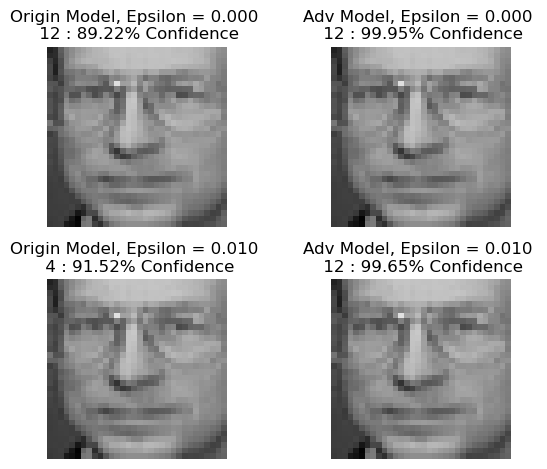

In [28]:
model.eval()
model_adv.eval()
adv_x1 = FGSM(model, x_test, y_test)
adv_x2 = FGSM(model_adv, x_test, y_test)

for i in range(x_test.shape[0]):
    img = x_test[i:i+1]
    label = y_test[i:i+1]
    if(torch.argmax(model(img), -1)[0] == label):
        adv_x = [adv_x1[i:i+1], adv_x2[i:i+1]]
        if(torch.argmax(model(img), -1)[0] != torch.argmax(model(adv_x[0]), -1)[0]):
            if(torch.argmax(model_adv(img), -1)[0] == torch.argmax(model_adv(adv_x[1]), -1)[0]):
                print("True Label : {}".format(label.item()))
                display_images(img, adv_x, model, model_adv)
                break
